# Task

1. Examine data, divide it into train/val/(test) splits
2. Preprocess photos: crop, align & normalize. It's allowed to use a pre-trained model for this pre-processing.
3. Convert pre-processed photos into embeddings using pre-trained model.
using a pre-trained model.
4. Build the index on these embeddings and store it on disk (use [FAISS](https://github.com/facebookresearch/faiss) or another framework).
5. Evaluate the model metrics (use PML).
6. Finish the implementation of the FaceSearch class
7. Demonstrate that it works on images from another dataset


*Optional
You can train your own model on the [LFW](http://vis-www.cs.umass.edu/lfw/) dataset and compare its metrics with the baseline.


... to be continued

#Load the LFW dataset

http://vis-www.cs.umass.edu/lfw/

In [2]:
!wget -nc https://ml.gan4x4.ru/hse/cv/lfw.tgz

File ‘lfw.tgz’ already there; not retrieving.



In [3]:
!tar -xvzf lfw.tgz

Streaming output truncated to the last 5000 lines.
lfw/Luis_Sanchez/
lfw/Luis_Sanchez/Luis_Sanchez_0001.jpg
lfw/Juliette_Binoche/
lfw/Juliette_Binoche/Juliette_Binoche_0001.jpg
lfw/Joel_Todd/
lfw/Joel_Todd/Joel_Todd_0001.jpg
lfw/Allan_Wagner/
lfw/Allan_Wagner/Allan_Wagner_0001.jpg
lfw/Alejandro_Fernandez/
lfw/Alejandro_Fernandez/Alejandro_Fernandez_0001.jpg
lfw/Guillaume_Depardieu/
lfw/Guillaume_Depardieu/Guillaume_Depardieu_0001.jpg
lfw/Delphine_Chuillot/
lfw/Delphine_Chuillot/Delphine_Chuillot_0001.jpg
lfw/Paul_LeClerc/
lfw/Paul_LeClerc/Paul_LeClerc_0001.jpg
lfw/Eddie_Jordan/
lfw/Eddie_Jordan/Eddie_Jordan_0001.jpg
lfw/Lionel_Richie/
lfw/Lionel_Richie/Lionel_Richie_0001.jpg
lfw/Lionel_Richie/Lionel_Richie_0002.jpg
lfw/Jose_Viegas_Filho/
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0001.jpg
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0002.jpg
lfw/Roger_Mahony/
lfw/Roger_Mahony/Roger_Mahony_0001.jpg
lfw/Clay_Aiken/
lfw/Clay_Aiken/Clay_Aiken_0001.jpg
lfw/Clay_Aiken/Clay_Aiken_0002.jpg
lfw/Clay_Ai

In [1]:
!pip install pytorch-lightning faiss-cpu pytorch-metric-learning torchmetrics torchinfo facenet_pytorch

In [7]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import cv2
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torchmetrics.functional import accuracy
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from torchvision.transforms import v2
from torchmetrics.classification import MulticlassAccuracy, MulticlassAUROC, MulticlassAveragePrecision, \
    MulticlassF1Score
import wandb

from torchinfo import summary

from torchvision.models import convnext_base, ConvNeXt_Base_Weights

from facenet_pytorch import MTCNN

device = "cuda" if torch.cuda.is_available() else "cpu"

## Create dataset & dataloader classes

In [8]:
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.uint8, scale=True),
        v2.Resize((224, 224)),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
    ]
)

dataset = ImageFolder('lfw', transform=transform)

## Make splits

In [9]:
# I don't want to select hyperparams, so validation sampling is not needed.

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

In [10]:
# I'll create new imageFolder, to check split
# There many unique people in test but maybe that's okay

import shutil


def copy_files(subset, target_dir):
    for index in subset.indices:
        path, class_idx = dataset.samples[index]
        class_name = dataset.classes[class_idx]

        # Create class directory if not exists
        class_folder = os.path.join(target_dir, class_name)
        os.makedirs(class_folder, exist_ok=True)

        # Copy the file
        shutil.copy(path, class_folder)


copy_files(train_dataset, "train_lfw")
copy_files(test_dataset, "test_lfw")

# Preprocess photos

In [11]:
train_transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.uint8, scale=True),
        v2.Resize((224, 224)),
        v2.RandomApply([v2.RandomRotation(degrees=15)], p=0.25),
        v2.RandomApply([v2.ColorJitter(brightness=0.05, hue=0.05)], p=0.5),
        v2.RandomApply([v2.RandomEqualize()], p=0.25),
        v2.RandomPerspective(distortion_scale=0.2, p=0.25),
        v2.RandomHorizontalFlip(p=0.5),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
    ]
)

test_transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.uint8, scale=True),
        v2.Resize((224, 224)),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
    ]
)

train_dataset = ImageFolder('train_lfw', transform=train_transform)
test_dataset = ImageFolder('test_lfw', transform=test_transform)

BATCH_SIZE = 64

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=6, persistent_workers=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                             num_workers=6, persistent_workers=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


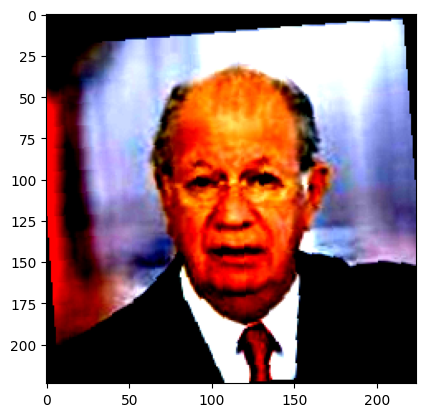

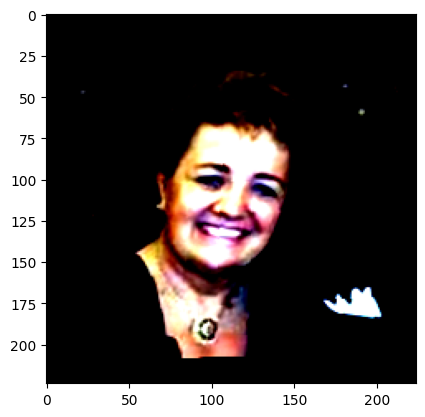

In [12]:
for batch in train_dataloader:
    images, class_nums = batch
    plt.imshow(images[0].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[1].permute(1, 2, 0))
    plt.show()
    break

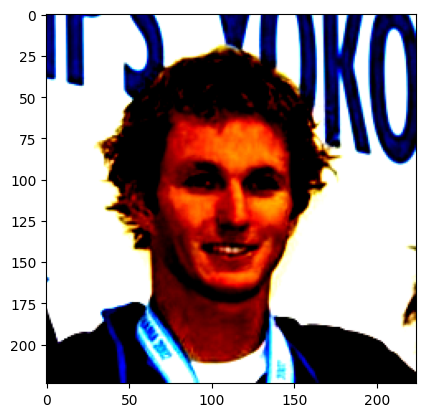

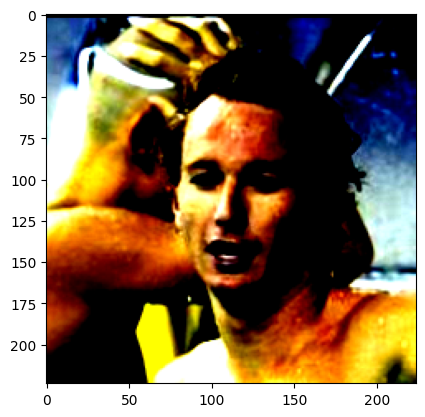

In [13]:
for batch in test_dataloader:
    images, class_nums = batch
    plt.imshow(images[0].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[1].permute(1, 2, 0))
    plt.show()
    break

Model

In [14]:
def get_model(emb_size: int = 256):
    model = convnext_base(weights=ConvNeXt_Base_Weights.IMAGENET1K_V1)

    for param in model.parameters():
        param.requires_grad = False

    model.classifier[2] = nn.Linear(in_features=1024, out_features=emb_size, bias=True)

    return model

In [15]:
trained_model = get_model(256)

summary(model=trained_model,
        input_size=(1, 3, 224, 224),  #[batch_size, color_channels, height, width]
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:06<00:00, 57.6MB/s]


Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ConvNeXt (ConvNeXt)                                     [1, 3, 224, 224]     [1, 256]             --                   Partial
├─Sequential (features)                                 [1, 3, 224, 224]     [1, 1024, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                         [1, 3, 224, 224]     [1, 128, 56, 56]     --                   False
│    │    └─Conv2d (0)                                  [1, 3, 224, 224]     [1, 128, 56, 56]     (6,272)              False
│    │    └─LayerNorm2d (1)                             [1, 128, 56, 56]     [1, 128, 56, 56]     (256)                False
│    └─Sequential (1)                                   [1, 128, 56, 56]     [1, 128, 56, 56]     --                   False
│    │    └─CNBlock (0)                                 [1, 128, 56, 56]     [1, 128, 56, 56]     (138,496)            

Lightning module

In [16]:
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

class PMLMetricWrapper():
    embeddings = None
    labels = None

    def __init__(self):
        self.calc = AccuracyCalculator()
        self.reset()

    def compute(self):
        accuracies = self.calc.get_accuracy(self.embeddings, self.labels)
        return accuracies

    def update(self, embeddings, labels):
        if len(embeddings) == 0 or len(labels) == 0:
            return
        self.labels = torch.cat((self.labels, labels.detach().cpu()), dim=0)
        self.embeddings = torch.cat((self.embeddings, embeddings.detach().cpu()))

    def reset(self):
        self.embeddings = torch.empty((0, 256))
        self.labels = torch.empty(0)


In [17]:
class Module(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion, detector = None):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.metrics = PMLMetricWrapper()
        self.lr = learning_rate
        self.detector = detector

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        embeddings = self.model(images)
        loss = self.criterion(embeddings, target)

        self.log("loss", loss, prog_bar=True, logger=True)

        return loss

    def on_validation_epoch_start(self):
        self.metrics.reset()

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        if len(images) == 0:
            self.log("empty_batch", 1, logger=False)
            return
        embeddings = self.model(images)
        self.metrics.update(embeddings, target)

    def on_validation_epoch_end(self):
        metrics = self.metrics.compute()
        self.log("mAP", metrics["mean_average_precision"], prog_bar=True, logger=True)


Loss

In [18]:
from pytorch_metric_learning.losses import ArcFaceLoss

model = get_model()

out = model(torch.randn(1, 3, 224, 224))
print(out.shape)

torch.Size([1, 256])


Loss Object

In [19]:
criterion = ArcFaceLoss(
    num_classes=len(train_dataset.classes),
    embedding_size=out.shape[1]
)

for name, p in criterion.named_parameters():
    print(name, p.shape)

W torch.Size([256, 4876])


Face detector

In [20]:
# face_detector = MTCNN(image_size=224)

## Training

In [21]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [22]:
run = wandb.init(project="hse-cv-hw4")

wandb: Currently logged in as: vldmrl (vldmrl-org). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [23]:
wandb_logger = WandbLogger(
    log_model='all',
    name='MTCNN_ConvNext_ArcFace'
)

In [24]:
module = Module(model, 0.001, criterion)#, face_detector)

In [25]:
EPOCHS = 10

In [26]:
checkpoint_callback_trainable = pl.callbacks.ModelCheckpoint(dirpath="best_weight_transfer",
                                                             save_top_k=2,
                                                             monitor="val_f1",
                                                             mode="max")

In [27]:
# torch.use_deterministic_algorithms(False)

trainer = pl.Trainer(logger=wandb_logger,
                     max_epochs=EPOCHS,
                     accelerator=device,
                     log_every_n_steps=10
)
trainer.fit(module, train_dataloader, test_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type        | Params | Mode 
--------------------------------------------------
0 | model     | ConvNeXt    | 87.8 M | train
1 | criterion | ArcFaceLoss | 1.2 M  | train
--------------------------------------------------
1.5 M     Trainable params
87.6 M    Non-trainable params
89.1 M    Total params
356.308   Total estimated model param

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


## Calculate metrics

- Check case where person's photo doesn't exist in embedding DB
- It's recommended to use [PML](https://github.com/KevinMusgrave/pytorch-metric-learning)

In [28]:
# В валидационной выборке полно уникальных классов (от этого могут быть сильные проблемы с метрикой)

print(module.metrics.compute())

{'AMI': 0.052064446630623526, 'NMI': 0.9001210608229322, 'mean_average_precision': 0.08198125912263754, 'mean_average_precision_at_r': 0.046555106029752366, 'mean_reciprocal_rank': 0.23800158500671387, 'precision_at_1': 0.17277913610431947, 'r_precision': 0.0769825994840952}


## Plot the DET curve

https://api.wandb.ai/links/vldmrl-org/lbmndiwj

# Implement class for face search

You can use faiss: https://github.com/facebookresearch/faiss

In [30]:
import faiss
import numpy as np

class FaceSearch(object):
    def __init__(self, threshold=0.1, dimension=512):
        self.threshold = threshold
        self.dimension = dimension
        self.index = faiss.IndexFlatL2(dimension)
        self.names = []

    def add_embeddings(self, embeddings, names):
        self.index.add(embeddings)
        self.names.extend(names)

    def __call__(self, image, model):
        image_tensor = preprocess(image)
        embedding = model(image_tensor.unsqueeze(0)).detach().cpu().numpy()

        distances, indices = self.index.search(embedding, k=1)

        if distances[0][0] < self.threshold:
            return self.names[indices[0][0]]
        return None


In [32]:
all_embeddings = []
all_names = []
for images, targets in train_dataloader:
    embeddings = module.model(images).detach().cpu().numpy()
    all_embeddings.append(embeddings)
    all_names.extend(targets)

all_embeddings = np.vstack(all_embeddings)

face_search = FaceSearch(threshold=0.5, dimension=256)
face_search.add_embeddings(all_embeddings, all_names)

RuntimeError: DataLoader worker (pid(s) 18484, 18486, 18490, 18492, 18494, 18500) exited unexpectedly

Здесь проиходит Runtime disconnection

## Demonstrate result on photos from CFPW dataset

http://www.cfpw.io/

Basically, you shouldn't change the following code, just run it

In [ ]:
!wget -nc http://www.cfpw.io/cfp-dataset.zip
!unzip cfp-dataset.zip

In [ ]:
from glob import glob
from pathlib import Path
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import os


class CFPWDataset(Dataset):  # CFPWDataset wrapper
    def __init__(self, root="cfp-dataset", transform=None):
        self.paths = glob(f"{root}/Data/Images/**/frontal/*")
        self.paths.sort()
        self.transform = transform
        with open(f"{root}/Data/list_name.txt", 'r') as file:
            self.names = file.readlines()

    def path2id(self, path):
        parts = path.split(os.sep)
        return int(parts[-3])

    def id2name(self, id):
        assert id < len(self.names)
        return self.names[id]

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, n):
        path = self.paths[n]
        img = Image.open(path)
        if self.transform:
            img = self.transform(img)
        id = self.path2id(path)
        name = self.id2name(id)
        return img, name


In [ ]:
import random

ds = CFPWDataset()

random.seed(42)
random_samples = random.choices(range(0, len(ds)), k=20)

searcher = FaceSearch()

for i in random_samples:
    img, name = ds[i]
    prediction = searcher(img)
    prediction = prediction if prediction is not None else "Not found"
    plt.figure(figsize=(3, 3))
    plt.title(f"GT: {name} predicted: {prediction}")
    plt.axis('off')
    plt.imshow(img)
plt.show()


#Place for conclusion

В целом результат по метрикам получились довольно посредственные, возможно нужно было по-другому разделять обучающую и тестовую выборку (без такого количества уникальных лиц), добавить свой семплер (для того, чтобы модель не переобучалась на людям с большим количеством фотографий). Ещё по графикам модель явно недоучилась, но вряд ли это сильно сможет улучшить итоговые метрики до адекватных значений. Скорее всего код в целом написан не совсем корректно, так как большую его часть я скопировал с презентации и предложенного ноутбука. Также использованные библиотеки часто конфликтовали и выдавали ошибки. Скорее всего на практике для такой задачи лучше использовать другие способы решения и использованный бейзлайн не слишком актуален.